<a href="https://colab.research.google.com/github/vutl/STR-Project/blob/main/STR_Recognition_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Download dataset
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
# https://drive.google.com/file/d/1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM/view
!gdown --id 1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
!unzip -q icdar2003.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 133MB/s]


## 1. Import libraries

In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import random
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

/home/aivn12s1/miniconda3/envs/thangdd_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Extract Data from XML and Store in New Folder

### Extract

In [ ]:
def extract_data_from_xml(root_dir):
    xml_path = os.path.join(root_dir, 'words.xml')
    tree = ET.parse(xml_path)
    root = tree.getroot()

    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    for img in root:
        bbs_of_img = []
        labels_of_img = []

        for bbs in img.findall('taggedRectangles'):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                    continue

                bbs_of_img.append(
                    [
                        float(bb.attrib['x']),
                        float(bb.attrib['y']),
                        float(bb.attrib['width']),
                        float(bb.attrib['height'])
                    ]
                )
                labels_of_img.append(bb[0].text.lower())

        img_path = os.path.join(root_dir, img[0].text)
        img_paths.append(img_path)
        img_sizes.append((int(img[1].attrib['x']), int(img[1].attrib['y'])))
        bboxes.append(bbs_of_img)
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes

In [ ]:
dataset_dir = 'datasets/SceneTrialTrain'
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(dataset_dir)

In [ ]:
print(f"Total images: {len(img_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")

Total images: 250
Total bounding boxes: 1097


### Plot an example

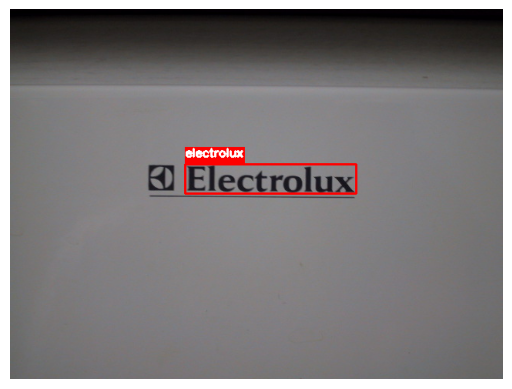

In [ ]:
def plot_image_with_bbs(img_path, bbs, labels):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for idx, bb in enumerate(bbs):
        start_point = (int(bb[0]), int(bb[1]))
        end_point = (int(bb[0] + bb[2]), int(bb[1] + bb[3]))
        color = (255, 0, 0)
        thickness = 2
        img = cv2.rectangle(img, start_point, end_point, color, thickness)

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 255, 255)
        line_type = 2
        text_thickness = 2
        label = labels[idx]
        text_size, _ = cv2.getTextSize(label, font, font_scale, text_thickness)


        label_background_start = (int(bb[0]), int(bb[1] - text_size[1] - 10))
        label_background_end = (int(bb[0] + text_size[0]), int(bb[1]))
        img = cv2.rectangle(img, label_background_start, label_background_end, color, cv2.FILLED)


        cv2.putText(
            img,
            label,
            (int(bb[0]), int(bb[1] - 10)),
            font,
            font_scale,
            font_color,
            text_thickness,
            line_type
        )

    plt.imshow(img)
    plt.axis('off')
    plt.show()


i = random.randint(0, len(img_paths))
plot_image_with_bbs(img_paths[i], bboxes[i], img_labels[i])

### Store all bounding boxes as a new dataset

In [ ]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    count = 0
    labels = []  # List to store labels

    for img_path, img_label, bbs in zip(img_paths, img_labels, bboxes):
        img = Image.open(img_path)

        for label, bb in zip(img_label, bbs):
            # Crop image
            cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))

            # filter out if 90% of the cropped image is black or white
            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue

            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue

            # Save image
            filename = f"{count:06d}.jpg"
            cropped_img.save(os.path.join(save_dir, filename))

            new_img_path = os.path.join(save_dir, filename)

            label = new_img_path + '\t' + label

            labels.append(label)  # Append label to the list

            count += 1

    print(f"Created {count} images")

    # Write labels to a text file
    with open(os.path.join(save_dir, 'labels.txt'), 'w') as f:
        for label in labels:
            f.write(f"{label}\n")

In [ ]:
save_dir = 'datasets/ocr_dataset'
split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

Created 1088 images


## 3. Read dataset

In [ ]:
root_dir = save_dir

img_paths = []
labels = []

# Read labels from text file
with open(os.path.join(root_dir, 'labels.txt'), 'r') as f:
    for label in f:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])

print(f"Total images: {len(img_paths)}")

Total images: 1088


## 4. Prepare vocabulary

In [ ]:
letters = [char.split(".")[0].lower() for char in labels]
letters = "".join(letters)
letters = sorted(list(set(list(letters))))

# create a string of all characters in the dataset
chars = "".join(letters)

# for "blank" character
blank_char = '-'
chars += blank_char
vocab_size = len(chars)

print(f'Vocab: {chars}')
print(f'Vocab size: {vocab_size}')

Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-
Vocab size: 37


In [ ]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [ ]:
max_label_len = max([len(label) for label in labels])

In [ ]:
def encode(label, char_to_idx, max_label_len):
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label],
        dtype=torch.long
    )
    label_len = len(encoded_labels)
    lengths = torch.tensor(
        label_len,
        dtype=torch.long
    )
    padded_labels = F.pad(
        encoded_labels,
        (0, max_label_len - label_len),
        value=0
    )

    return padded_labels, lengths

In [ ]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)

        decoded_sequences.append(''.join(decoded_label))

    return decoded_sequences

## 5. Create data preprocessing function

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=1, shear=1),
        transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
    'val': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
}

## 6. Train, val, test split

In [ ]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

## 7. Create pytorch dataset

In [ ]:
class STRDataset(Dataset):
    def __init__(
        self,
        X, y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label,
                self.char_to_idx,
                self.max_label_len
            )
        return img, encoded_label, label_len

## 8. Create dataloader

In [ ]:
train_dataset = STRDataset(
    X_train, y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['train']
)
val_dataset = STRDataset(
    X_val, y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)
test_dataset = STRDataset(
    X_test, y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)

In [ ]:
print(f"Train dataset: {len(train_dataset)}", f"Val dataset: {len(val_dataset)}", f"Test dataset: {len(test_dataset)}", sep='\n')

Train dataset: 761
Val dataset: 218
Test dataset: 109


In [ ]:
train_batch_size = 32
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

['floor', 'mexican', 'guinness', 'an', 'galvin', 'isuzu', 'my', 'to', 'your', 'can', 'imported', 'to', 'mortgages', 'sad', 'somerton', 'operation', 'road', 'mobile', 'professional', 'please', 'made', 'xtra', 'riverside', 'house', 'no', 'office', 'approach', 'physical', 'code', 'signals', 'footway', 'a134']


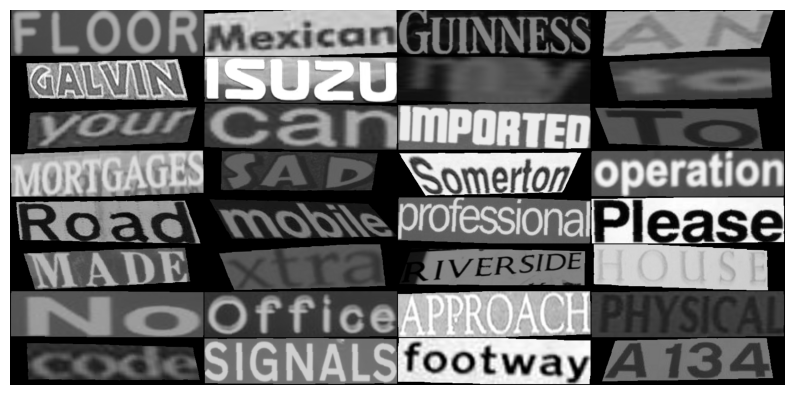

In [ ]:
train_features, train_labels, train_lengths = next(iter(train_loader))

# use torchvision to display a grid of images
def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    print(labels)
    plt.show()

show_batch(train_features, train_labels)

## 9. Create model

In [ ]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3):
        super(CRNN, self).__init__()

        backbone = timm.create_model(
            'resnet101',
            in_chans=1,
            pretrained=True
        )
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.lstm = nn.LSTM(
            512, hidden_size,
            n_layers, bidirectional=True, batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x = self.mapSeq(x)
        x, _ = self.lstm(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2) # Based on CTC

        return x

In [ ]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers=3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers
).to(device)

In [ ]:
model.eval()

dummy_tensor = torch.rand((64, 1, 100, 420)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([14, 64, 37])


## 10. Training

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                5
            )
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

        scheduler.step()

    return train_losses, val_losses

In [ ]:
epochs = 100
lr = 0.001
weight_decay=1e-5
scheduler_step_size = epochs * 0.4

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 4.2350	Val loss: 3.8063
EPOCH 2:	Train loss: 3.5230	Val loss: 3.4833
EPOCH 3:	Train loss: 3.4020	Val loss: 3.4674
EPOCH 4:	Train loss: 3.2737	Val loss: 3.3083
EPOCH 5:	Train loss: 3.0089	Val loss: 3.0442
EPOCH 6:	Train loss: 2.7299	Val loss: 2.7941
EPOCH 7:	Train loss: 2.4106	Val loss: 2.4425
EPOCH 8:	Train loss: 2.0683	Val loss: 2.0739
EPOCH 9:	Train loss: 1.6665	Val loss: 1.7921
EPOCH 10:	Train loss: 1.3355	Val loss: 1.4708
EPOCH 11:	Train loss: 1.0806	Val loss: 1.3984
EPOCH 12:	Train loss: 0.9070	Val loss: 1.2445
EPOCH 13:	Train loss: 0.7567	Val loss: 1.2226
EPOCH 14:	Train loss: 0.7110	Val loss: 1.0825
EPOCH 15:	Train loss: 0.6035	Val loss: 0.9752
EPOCH 16:	Train loss: 0.4918	Val loss: 1.1918
EPOCH 17:	Train loss: 0.4615	Val loss: 1.0801
EPOCH 18:	Train loss: 0.4367	Val loss: 1.0798
EPOCH 19:	Train loss: 0.4071	Val loss: 0.9820
EPOCH 20:	Train loss: 0.3887	Val loss: 0.8523
EPOCH 21:	Train loss: 0.3108	Val loss: 0.8777
EPOCH 22:	Train loss: 0.2524	Val loss: 0.98

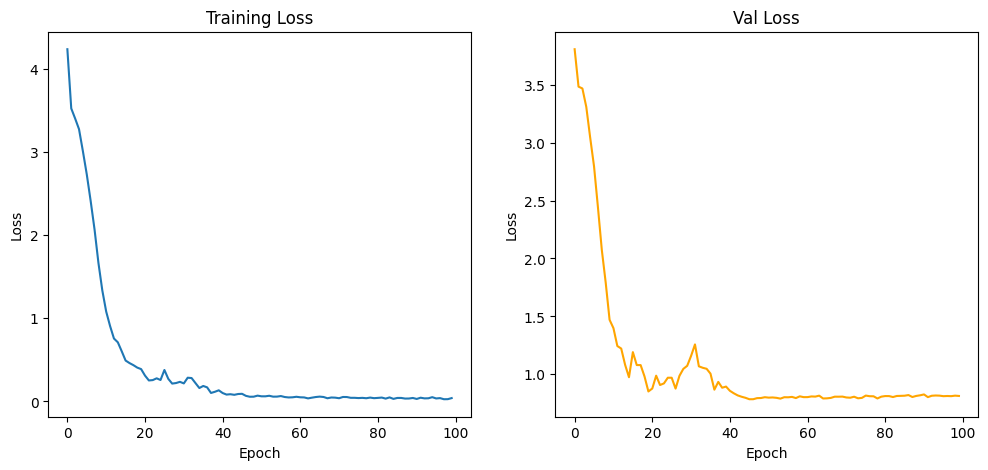

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## 11. Evaluation

In [ ]:
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  0.813525524389531
Test loss:  0.9885465949773788


## 12. Make Predictions

In [ ]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)

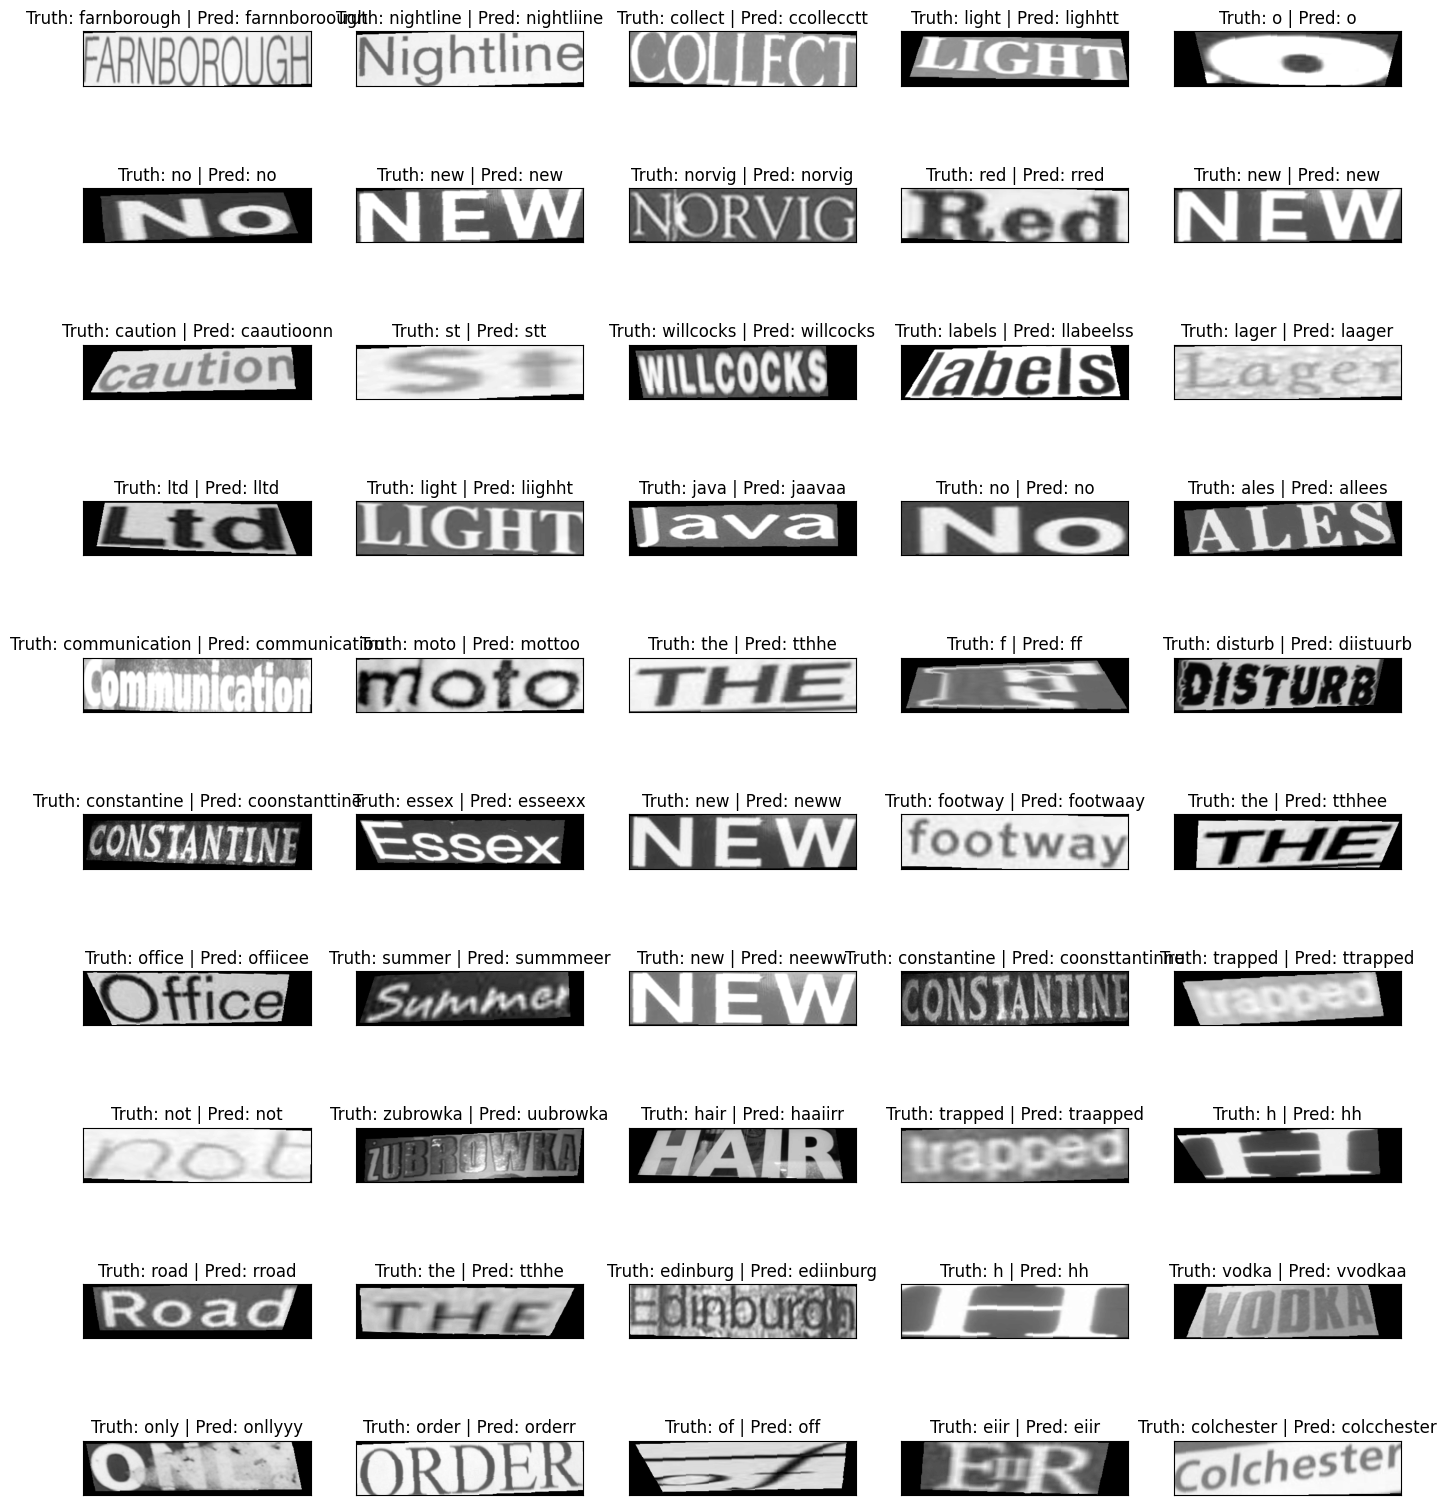

In [ ]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(title)

plt.show()

### Test dataset

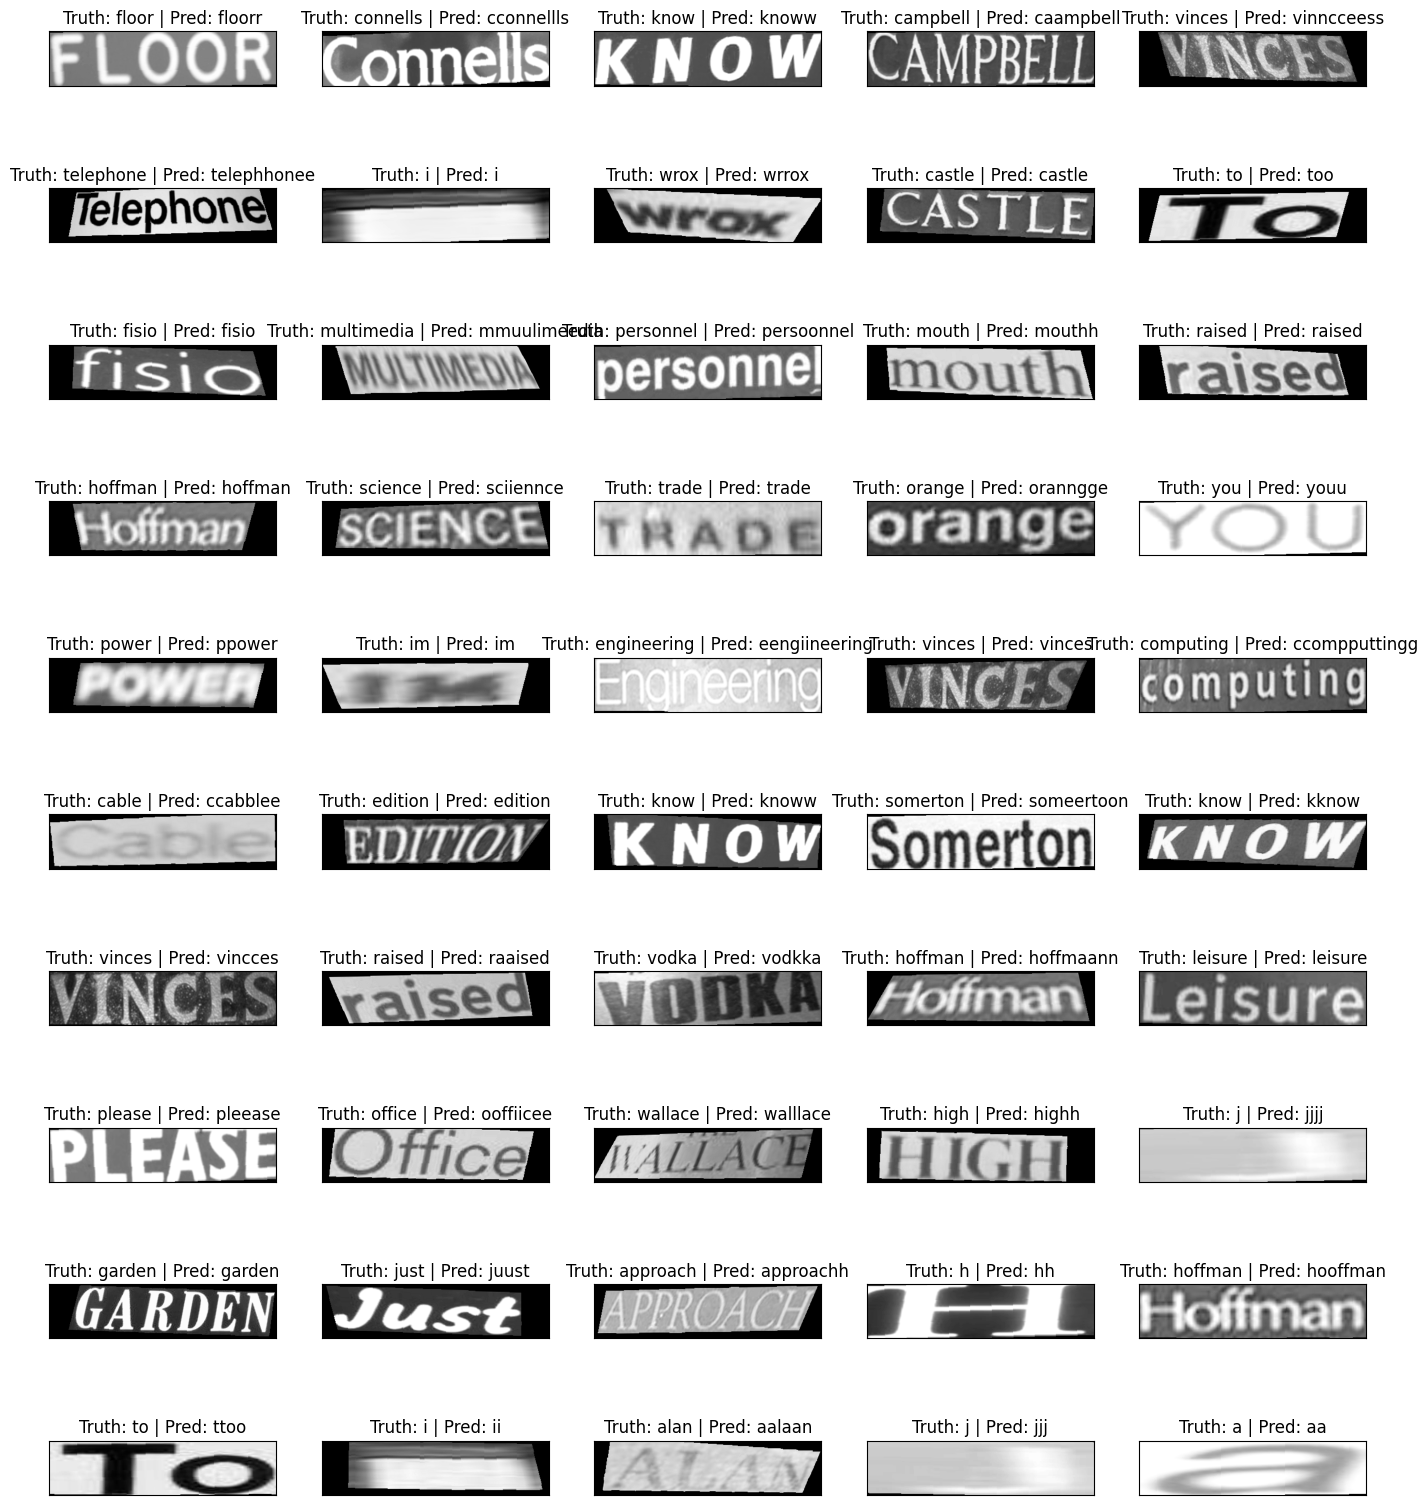

In [ ]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(title)

plt.show()

## 13. Save model

In [ ]:
save_model_path = 'models/ocr_crnn_base_best.pt'
torch.save(model.state_dict(), save_model_path)